# Calculate the annual precipitation timeseries from ERA5

**This notebook demonstrates how to retrieve, process, and plot the data displayed in the [ERA Explorer](https://apps.climate.copernicus.eu/era-explorer/)**

==> For further training materials, consider the [Copernicus Climate Change Service (C3S) data tutorials](https://ecmwf-projects.github.io/copernicus-training-c3s/intro.html)

In this example we will be using `earthkit` to retrieve the data and standard `Python` packages to process and plot it.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import earthkit.data

If you want to run this code yourself, make sure to get a CDS API key from [the CDS website](https://cds.climate.copernicus.eu/).

Following the guidance there, you'll then need to set up your local `.cdsapirc` to be able to authenticate with the CDS and download data. Then, you will be able to customise the date ranges, variables, and much more!

This is the latitude/longitude that we will extract the nearest grid cell from. You can change these to plot different locations. You can see the currently used ones in the ERA Explorer URL. In this example we are plotting data at the gridpoint closest to Brussels, Belgium. 

In [3]:
## updated for HEF
lat = 46.79
lng = 10.74


This is the variable we are getting from the ERA dataset, and the time period

In [4]:
variable = "total_precipitation"
date_range = ["1940-01-01", "2100-12-31"]

For convenience, we make a function to handle the data retrieval:

In [5]:
def retrieve_data(variable, date_range, lat, lng):
    # Define the dataset and request parameters
    dataset = "reanalysis-era5-single-levels-timeseries"
    request = {
        "variable": [
        variable,  # Variable to retrieve
        ],
        "date": date_range,  # Date range for the data
        "location": {"longitude": lng, "latitude": lat},  # Location coordinates
        "data_format": "netcdf"  # Format of the retrieved data
    }

    # Use "earthkit" to retrieve the data
    ekds = earthkit.data.from_source(
        "cds", dataset, request
    ).to_xarray()

    return ekds

Now let's download the data!

In [6]:
data = retrieve_data(variable, date_range, lat, lng)

2025-04-16 14:49:44,365 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-16 14:49:44,367 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-16 14:49:44,507 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-16 14:49:44,509 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-16 14:49:44,700 WARNING [2025-03-17T00:00:00] Please be aware that the generation of this dataset 

c7d2368375ba054765e6023f60b44f9f.zip:   0%|          | 0.00/8.57M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

And let's make some bespoke functions to process the data. Each one is described with a """`docstring`"""

In [17]:
def truncate_data(var):
    """
    Truncate the input dataset to include only complete years where the final hour
    of December 31st is present in the dataset.

    Args:
        var (xarray.Dataset or xarray.DataArray): Input dataset containing a 'valid_time'
                                                  coordinate with datetime information.

    Returns:
        xarray.Dataset or xarray.DataArray: The truncated dataset containing data
                                            only for complete years.
    """
    # Create a range of the final hours of each year in the dataset
    start_year = var.valid_time.dt.year.min().item()
    end_year = var.valid_time.dt.year.max().item()

    final_hours = pd.date_range(
        f"{start_year}-12-31T23:00:00", 
        f"{end_year}-12-31T23:00:00", 
        freq="YE"
    )

    # Filter only the years where the final hour is in the dataset
    valid_years = [
        dt.year for dt in final_hours if dt in var.valid_time
    ]

    # Select data for those years
    var_truncated = var.sel(
        valid_time=var.valid_time.dt.year.isin(valid_years)
    )

    return var_truncated


# Function to compute the annual mean precipitation time series
def precipAnnualTimeseries():
    """
    Processes the annual timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to annual sums, and
    converts the values to millimeters.

    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): Years corresponding to the annual precip sums.
            - values (numpy.ndarray): Annual precipitation sums in millimeters.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="YE"
    ).sum() * 1000

    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    return years, values, nearest_lat, nearest_lng

def precipHydroyearTimeseries():
    """
    Processes the annual timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to annual sums, and
    converts the values to millimeters.

    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): Years corresponding to the annual precip sums.
            - values (numpy.ndarray): Annual precipitation sums in millimeters.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="YE-SEP"  ## Check this is right.
    ).sum() * 1000

    years = data_tp_pt_agg.valid_time.to_index().year # 2023/2024 year is 2024 hydro year.
    values = data_tp_pt_agg.values.flatten()

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    return years, values, nearest_lat, nearest_lng



# Call the function and retrieve the data
#years1, ts1, nearest_lat, nearest_lng = precipAnnualTimeseries()
years1, ts1, nearest_lat, nearest_lng = precipHydroyearTimeseries()

print(years1, ts1)


<xarray.DataArray 'tp' (valid_time: 86)> Size: 344B
dask.array<mul, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 8B ...
    longitude   float64 8B ...
  * valid_time  (valid_time) datetime64[ns] 688B 1940-09-30 ... 2025-09-30
Index([1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026],
      dtype='int32', name='valid_time') [ 691.1042   879.09033  801.93304  866.9357   834.89514  972.40186
  898.2315   790.1473  1112.1641 

In [13]:
print(years1, ts1, nearest_lat, nearest_lng)

# I want to save in a data frame. 

import pandas as pd

# Call the function to get the data
years1, ts1, nearest_lat, nearest_lng = precipAnnualTimeseries()
df.to_pickle("precip_annual_data.pkl")

years1, ts1, nearest_lat, nearest_lng = precipHydroyearTimeseries()


# Create a pandas DataFrame
df = pd.DataFrame({
    'calendar_year': years1,
    'tp': ts1,
    'Latitude': [nearest_lat] * len(years1),  # Repeat lat for all rows
    'Longitude': [nearest_lng] * len(years1)  # Repeat lng for all rows
})

# Display DataFrame
print(df.head())

df.to_pickle("precip_annual_data.pkl")


Index([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024],
      dtype='int32', name='valid_time') [ 865.65063  839.2174   793.81323  826.1564  1025.6453   856.3674
  851.32935  944.00977  974.9856   911.76917  986.4907  1217.2882
 1047.9161   847.2095  1118.783    934.9749   969.65076  917.804
 1167.2843   970.95966 1186.8849   885.40027 1006.75916 1136.5216
  994.1854  1155.4468  1301.5623  1101.067   1132.5503   901.75604
 1104.1643   855.77057 1034.0266  1028.538   1129.9426  1049.55

And finally, let's set up the plot nicely. This can easily be customised, but for now we do something similar to [ERA Explorer](https://apps.copernicus-climate.eu/c3s-apps/era-explorer)

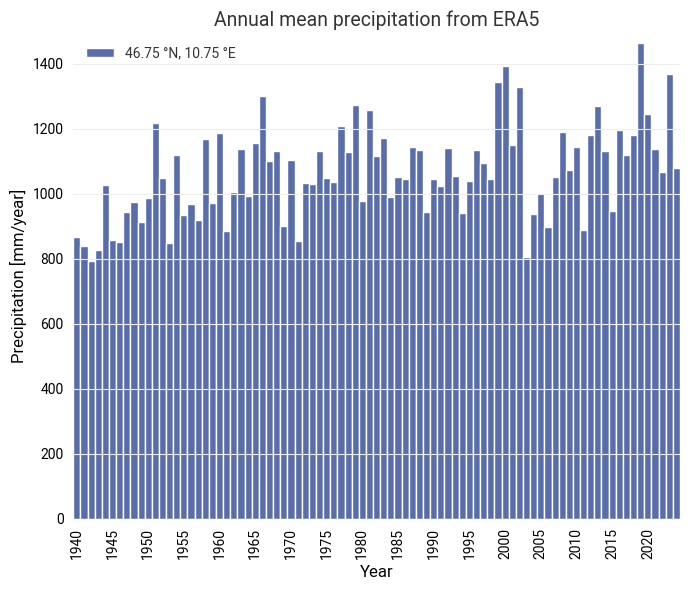

In [14]:
# Determine suffix for latitude (N/S) and longitude (E/W) based on their sign
latSuffix = 'N' if nearest_lat > 0 else 'S'  # 'N' for +ve latitude, 'S' for -ve latitude
lngSuffix = 'E' if nearest_lng > 0 else 'W'  # 'E' for +ve longitude, 'W' for -ve longitude

# Create a new figure with a specified size
plt.figure(figsize=(7, 6))

# Plot the data as a bar chart
plt.bar(
    years1,                # X-axis values (years)
    ts1,                   # Y-axis values (precipitation values)
    width=1,               # Set the width of each bar to 1 unit
    color='#596DAB',       # Bar fill color
    label=(
        f'{abs(nearest_lat):.2f} °{latSuffix}, '
        f'{abs(nearest_lng):.2f} °{lngSuffix}'
    ),                     # Location label for the legend
    edgecolor='white',     # Color of the edges of the bars
)

# Add a legend with a transparent background
plt.legend(framealpha=0)

# Customize x-axis ticks
plt.xticks(
    np.arange(1940, 2100, 5),  # X-ticks every 5 years
    rotation=90                # Rotate tick labels vertically
)

# Set x-axis limits with a small buffer at the edges
plt.xlim(years1[0] - 0.5, years1[-1] + 0.5)

# Add minor ticks on the x-axis (every year)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every 1 year

# Customize axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Precipitation [mm/year]', fontsize=12)

# Add a title to the plot
plt.title('Annual mean precipitation from ERA5', fontsize=14)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

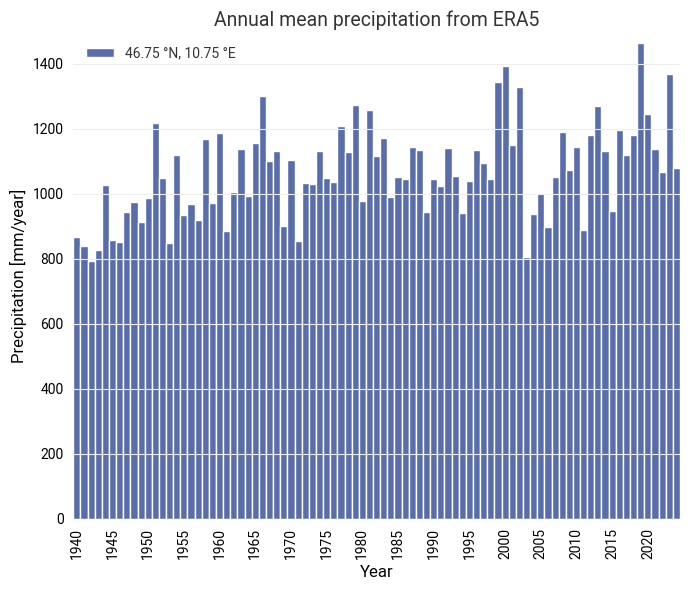

In [15]:
# Determine suffix for latitude (N/S) and longitude (E/W) based on their sign
latSuffix = 'N' if nearest_lat > 0 else 'S'  # 'N' for +ve latitude, 'S' for -ve latitude
lngSuffix = 'E' if nearest_lng > 0 else 'W'  # 'E' for +ve longitude, 'W' for -ve longitude

# Create a new figure with a specified size
plt.figure(figsize=(7, 6))

# Plot the data as a bar chart
plt.bar(
    years1,                # X-axis values (years)
    ts1,                   # Y-axis values (precipitation values)
    width=1,               # Set the width of each bar to 1 unit
    color='#596DAB',       # Bar fill color
    label=(
        f'{abs(nearest_lat):.2f} °{latSuffix}, '
        f'{abs(nearest_lng):.2f} °{lngSuffix}'
    ),                     # Location label for the legend
    edgecolor='white',     # Color of the edges of the bars
)

# Add a legend with a transparent background
plt.legend(framealpha=0)

# Customize x-axis ticks
plt.xticks(
    np.arange(1940, 2100, 5),  # X-ticks every 5 years
    rotation=90                # Rotate tick labels vertically
)

# Set x-axis limits with a small buffer at the edges
plt.xlim(years1[0] - 0.5, years1[-1] + 0.5)

# Add minor ticks on the x-axis (every year)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every 1 year

# Customize axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Precipitation [mm/year]', fontsize=12)

# Add a title to the plot
plt.title('Annual mean precipitation from ERA5', fontsize=14)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()